In [1]:
from path_planning import MapReader
from path_finding import PathPlanner
import numpy as np
import json
import matplotlib.pyplot as plt
import time

In [2]:
def main():
    print("Path planning initialized...")

    mapReader = MapReader(map_fname='test_truemap_cv.txt',search_list='test_search_list.txt')

    fruits, fruit_positions, aruco_positions = mapReader.load_map_data()
    print(fruits)

    start_x, start_y = 0, 0  # starting position

    search_targets = mapReader.read_search_list()
    goals = PathPlanner.compute_goal_positions(fruits, fruit_positions, search_targets)
    print(search_targets)
    print(goals)

    planner = PathPlanner(grid_resolution=0.1, robot_radius=0.1, target_radius=5)


    for fruit in fruit_positions:
        planner.add_obstacle(fruit[0], fruit[1], 0.1)

    for ox, oy in zip(aruco_positions[:, 0],aruco_positions[:, 1]):
        planner.add_obstacle(ox, oy, 0.1)

    goal_count = 0
    show_visualization = True

    with open('waypoint.txt', 'w') as file:  # Open file once in write mode
        for goal in goals:
            goal_count += 1
            path_x, path_y = planner.plan_path(start_x, start_y, goal[0], goal[1])
            print(goal)

            if show_visualization:
                plt.plot(planner.obstacle_x, planner.obstacle_y, ".k")
                plt.plot(start_x, start_y, "og")
                plt.plot(goal[0], goal[1], "xb")
                plt.grid(True)
                plt.axis("equal")
                plt.plot(path_x, path_y, "-r")
                plt.show()

            # Write waypoints to file
            file.write(f"Target{goal_count}\n")
            for x, y in zip(path_x, path_y):
                file.write(f"{x},{y}\n")

            start_x, start_y = path_x[0], path_y[0]


Path planning initialized...
['redapple', 'greenapple', 'orange', 'mango', 'capsicum']
['redapple', 'greenapple', 'orange']
[array([-1.2,  1. ]), array([0. , 1.2]), array([ 0.2, -0.4])]
time to add obstacles 0.0
time to build grid 0.5674240589141846
time to add obstacles 0.0
time to build grid 0.6500723361968994
time to add obstacles 0.0
time to build grid 0.6401925086975098
time to add obstacles 0.0
time to build grid 0.6658616065979004
time to add obstacles 0.0
time to build grid 0.7053542137145996
time to add obstacles 0.0
time to build grid 0.7054762840270996
time to add obstacles 0.0
time to build grid 0.716874361038208
time to add obstacles 0.0
time to build grid 0.7725837230682373
time to add obstacles 0.0
time to build grid 0.8507590293884277
time to add obstacles 0.0
time to build grid 0.7574789524078369
time to add obstacles 0.0
time to build grid 0.8603954315185547
time to add obstacles 0.0
time to build grid 0.8158588409423828
time to add obstacles 0.0
time to build grid 0.

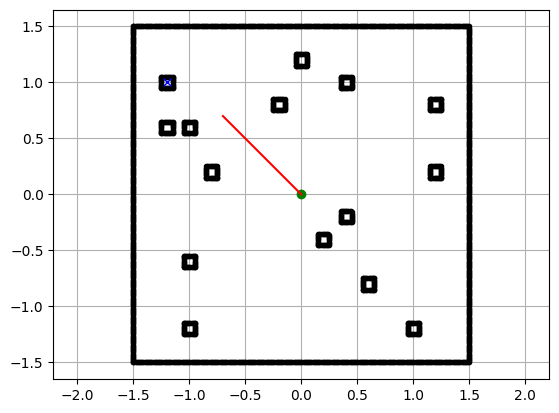

Navigation Time: 0.0
[0.  1.2]


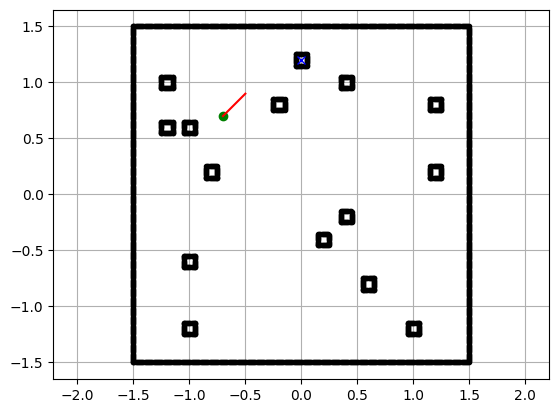

Navigation Time: 0.0
[ 0.2 -0.4]


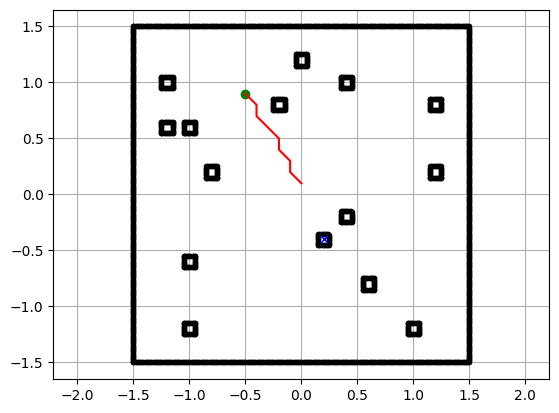

In [3]:
main()

In [4]:
print("Path planning initialized...")

mapReader = MapReader(map_fname='test_truemap_cv.txt',search_list='test_search_list.txt')

fruits, fruit_positions, aruco_positions = mapReader.load_map_data()
print(fruits)

start_x, start_y = 0, 0  # starting position

search_targets = mapReader.read_search_list()
goals = PathPlanner.compute_goal_positions(fruits, fruit_positions, search_targets)
print(search_targets)
print(goals)

st = time.time()
planner = PathPlanner(grid_resolution=0.06, robot_radius=0.1, target_radius=5)
print("Duration of instantiate PathPlanner:" + str(time.time()-st))

st = time.time()
for fruit in fruit_positions:
    planner.add_obstacle(fruit[0], fruit[1], 0.1)

for ox, oy in zip(aruco_positions[:, 0],aruco_positions[:, 1]):
    planner.add_obstacle(ox, oy, 0.1)
print("Duration of adding obstacles:" + str(time.time()-st))

planner.export_obstacle_grid()

goal_count = 0
show_visualization = True

goal = goals[0]
path_x, path_y = planner.plan_path(start_x, start_y, goal[0], goal[1])


Path planning initialized...
['redapple', 'greenapple', 'orange', 'mango', 'capsicum']
['redapple', 'greenapple', 'orange']
[array([-1.2,  1. ]), array([0. , 1.2]), array([ 0.2, -0.4])]
Duration of instantiate PathPlanner:0.0
time to add obstacles 0.0
time to build grid 1.6502149105072021
time to add obstacles 0.0
time to build grid 1.683734655380249
time to add obstacles 0.0
time to build grid 1.759352445602417
time to add obstacles 0.0
time to build grid 1.7802186012268066
time to add obstacles 0.0
time to build grid 1.8986949920654297
time to add obstacles 0.0
time to build grid 1.9219672679901123
time to add obstacles 0.0
time to build grid 1.997941493988037
time to add obstacles 0.0
time to build grid 1.962118148803711
time to add obstacles 0.0
time to build grid 2.1151375770568848
time to add obstacles 0.0
time to build grid 2.165165662765503
time to add obstacles 0.0
time to build grid 2.1460230350494385
time to add obstacles 0.0
time to build grid 2.1841423511505127
time to add

In [5]:
path_x, path_y = planner.plan_path(start_x, start_y, goal[0], goal[1])

Navigation Time: 0.0


Navigation Time: 0.0015659332275390625
[-1.2  1. ]


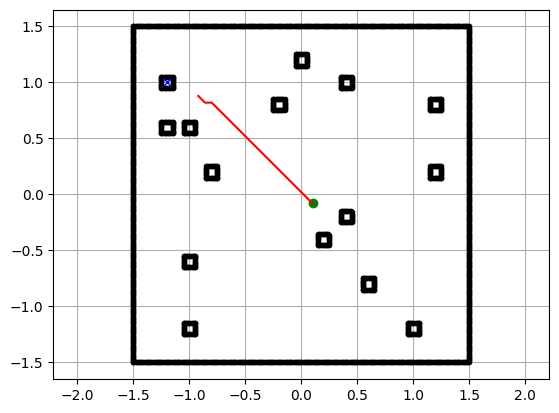

Navigation Time: 0.0
[0.  1.2]


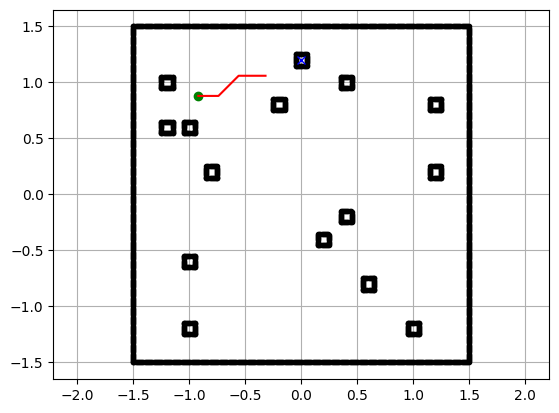

Navigation Time: 0.0
[ 0.2 -0.4]


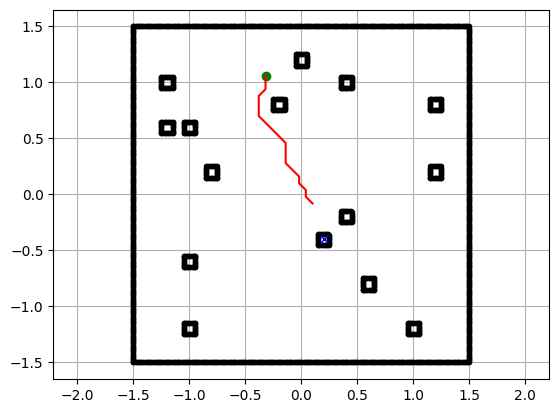

In [8]:
new_planner = PathPlanner(grid_resolution=0.06, robot_radius=0.1, target_radius=5)
planner.import_obstacle_grid(r"C:\Users\Public\ECE4078\project\obstacle_grid.txt")

with open('waypoint.txt', 'w') as file:  # Open file once in write mode
    for goal in goals:
        goal_count += 1
        path_x, path_y = planner.plan_path(start_x, start_y, goal[0], goal[1])
        print(goal)

        if show_visualization:
            plt.plot(planner.obstacle_x, planner.obstacle_y, ".k")
            plt.plot(start_x, start_y, "og")
            plt.plot(goal[0], goal[1], "xb")
            plt.grid(True)
            plt.axis("equal")
            plt.plot(path_x, path_y, "-r")
            plt.show()

        # Write waypoints to file
        file.write(f"Target{goal_count}\n")
        for x, y in zip(path_x, path_y):
            file.write(f"{x},{y}\n")

        start_x, start_y = path_x[0], path_y[0]

The purpose of this jupyter notebook is to see what is the reason behind slow calculation of algo.Besides, we could also demo the functionality of path_finding package via code above.